# Курс ["Алгоритмы анализа данных"](https://gb.ru/lessons/177362)

# Урок 6. Градиентный бустинг (AdaBoost)

### Модель с урока

In [ ]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

In [ ]:
from sklearn.datasets import load_diabetes

In [ ]:
X, y = load_diabetes(return_X_y=True)

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [ ]:
def gb_predict(X, trees_list, coef_list, eta):
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [ ]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [ ]:
def bias(y, z):
    return (y - z)

In [ ]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [ ]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

## Задание1. 

### 1.1. Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    trees = []    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        if len(trees) == 0:
            tree.fit(X_train, y_train)
        else:
            target = gb_predict(X_train, trees, coefs, eta)
            tree.fit(X_train, bias(y_train, target))

        trees.append(tree)
    
    train_error = mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta))
    test_error = mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta))

    return train_error, test_error

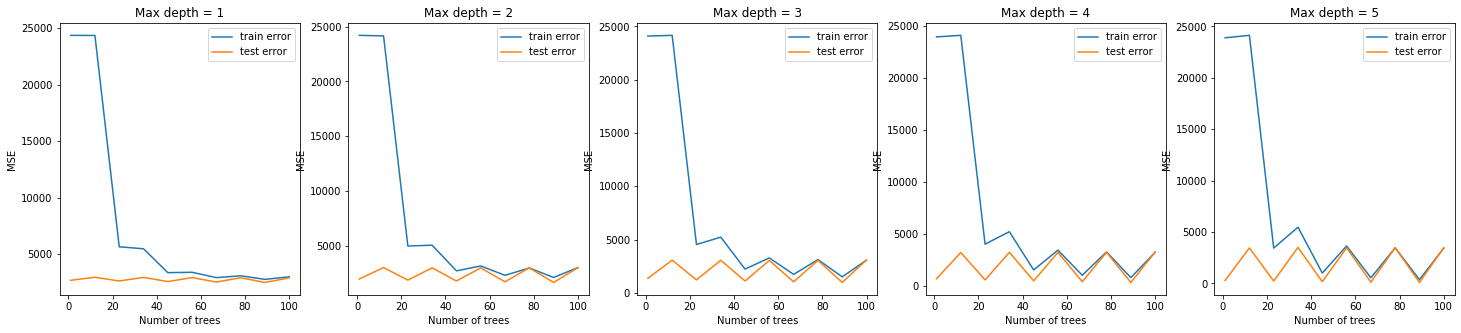

In [ ]:
eta = 0.1
n_trees_arr = np.linspace(1, 100, 10, dtype=np.dtype('int32'))
max_depth_arr = np.arange(1,6)
errors = []

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,5))
ind = 0

for ind_col, max_depth in enumerate(max_depth_arr):
    errors = []
    for n_trees in n_trees_arr: 
        coefs = [1] * n_trees
        train_error, test_error = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
        errors.append([train_error, test_error])
    
    errors = np.array(errors).reshape(2, -1)

    ax_ = ax[ind_col]
    ax_.plot(n_trees_arr, errors[0],  label='train error')
    ax_.plot(n_trees_arr, errors[1],  label='test error')
    ax_.legend(loc='upper right')
    ax_.set_title(f'Max depth = {max_depth}')
    ax_.set_xlabel('Number of trees')
    ax_.set_ylabel('MSE')
    

### 1.2. Сделать выводы о зависимости ошибки от этих параметров. Подобрать оптимальные значения этих гиперпараметров.

При увеличении количества деревье ошибка на трейне уменьшается.

При увеличении максимальной глубины дерева, ошибка на трейне становится синусообразной в зависимости от длины дерева. Ошибка на трейне становится больше похожей на ошибку на тесте с увеличением числа деревьев.

## Задание 2. (*) 

### Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [ ]:
def gb_s_fit(n_trees, max_depth, X_train_all, X_test, y_train_all, y_test, coefs, eta, sample_coef):

    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    

    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        
        # создаю подвыборку
        s = int(X_train_all.shape[0] * sample_coef)
        con_xy = np.c_[X_train_all, y_train_all]
        data = np.random.permutation(con_xy)[:s]
        X_train = data[:, :-1]
        y_train = data[:, -1]

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [ ]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees_1, train_errors_1, test_errors_1 = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
trees_2, train_errors_2, test_errors_2 = gb_s_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, sample_coef=0.5)


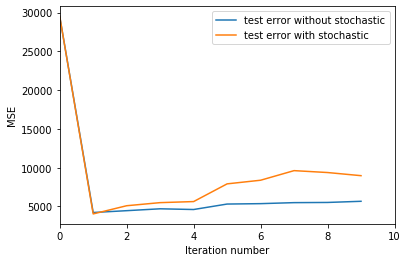

In [ ]:
plt.xlabel('Iteration number')
plt.ylabel('MSE')
plt.xlim(0, n_trees)
plt.plot(list(range(n_trees)), test_errors_1, label='test error without stochastic')
plt.plot(list(range(n_trees)), test_errors_2, label='test error with stochastic')
plt.legend(loc='upper right')
plt.show()